# Imports

In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
 
import P3_helpers as hlp
from P3_helpers import get_dataframe, get_parsed_comment, get_LDA_model, tokenize_one_comment, get_LDA_model_from_saved_file

import json
import matplotlib.pyplot as plt

---
# Topic Modeling

## Loading and preprocessing DF

In [2]:
df = get_dataframe()
df.columns

Index(['Source', 'Target', 'Vote', 'Results', 'Year', 'Date', 'Comment'], dtype='object')

In [3]:
df['Parsed_Comment'] = df['Comment'].apply(get_parsed_comment)
df['Tokenized_Comment_not_filtered'] = df['Parsed_Comment'].apply(tokenize_one_comment)
df['BoW'] = hlp.get_bow_column(df['Tokenized_Comment_not_filtered'])


## Computing and saving topic models

In [4]:
isTrainSession = False

if isTrainSession:
    comments_series = df['Parsed_Comment'].copy(deep=True)
    topic_range = range(3, 10, 2)
    for nb_topics in topic_range:
        print(f"nb_topics: {nb_topics}")
        lda = get_LDA_model(comments_series=comments_series, num_topics=nb_topics, lemmatize=True)
        print(f"Saving model for {nb_topics} topics")
        lda.save(fname=f"lda_model_{nb_topics}_all_true_lemma")
        print(f"Topic_{nb_topics} done")

## Loading pre-computed models

In [5]:
models = []
nb_topics = range(3, 10, 2)

for nb_topic in nb_topics:
    models.append(get_LDA_model_from_saved_file(f"./topic_model_states_dict/lda_model_{nb_topic}_all_true_lemma"))

## Infer Topics by Comment

In [6]:
for i, model in enumerate(models):
    df[f'Topics_from_{nb_topics[i]}'] = df['BoW'].apply(model.get_document_topics)


In [7]:
new_save = False
if new_save:
    df.to_csv('df_with_topics_plus_lemma.csv', index=False)

In [8]:
for i, model in enumerate(models):
    d = model.print_topics(num_words=15)
    d = {topic[0]:topic[1] for topic in d}
    with open(f"topics_{nb_topics[i]}_dict_with_lemma.json", 'w') as f:
        json.dump(d,f)

--- 
# Statistics

In [9]:
df = hlp.get_df_with_topics_from_csv(path='df_with_topics_plus_lemma.csv')
df = df[['Parsed_Comment', 'BoW', 'Topics_from_3', 'Topics_from_5', 'Topics_from_7', 'Topics_from_9']]

In [10]:
nb_topics = range(3, 10, 2)
topic_positions = ['first', 'second', 'third', 'fourth', 'fifth']

df_top_stat = hlp.get_topic_stat(df.copy(deep=True), nb_topics=nb_topics, topic_positions=topic_positions)
stats_dict = hlp.get_stats_dict_from_df_with_topics(df_top_stat, nb_topics=nb_topics, topic_positions=topic_positions)

topics_dict = hlp.topic_dict_function(path_dir='./topic_dicts_wtih_lemma')
topic_description_dict = hlp.topic_str_plot(topics_dict)

with open('./topic_dicts/topic_description_dict_with_lemma.json', 'w') as f:
    json.dump(topic_description_dict,f)

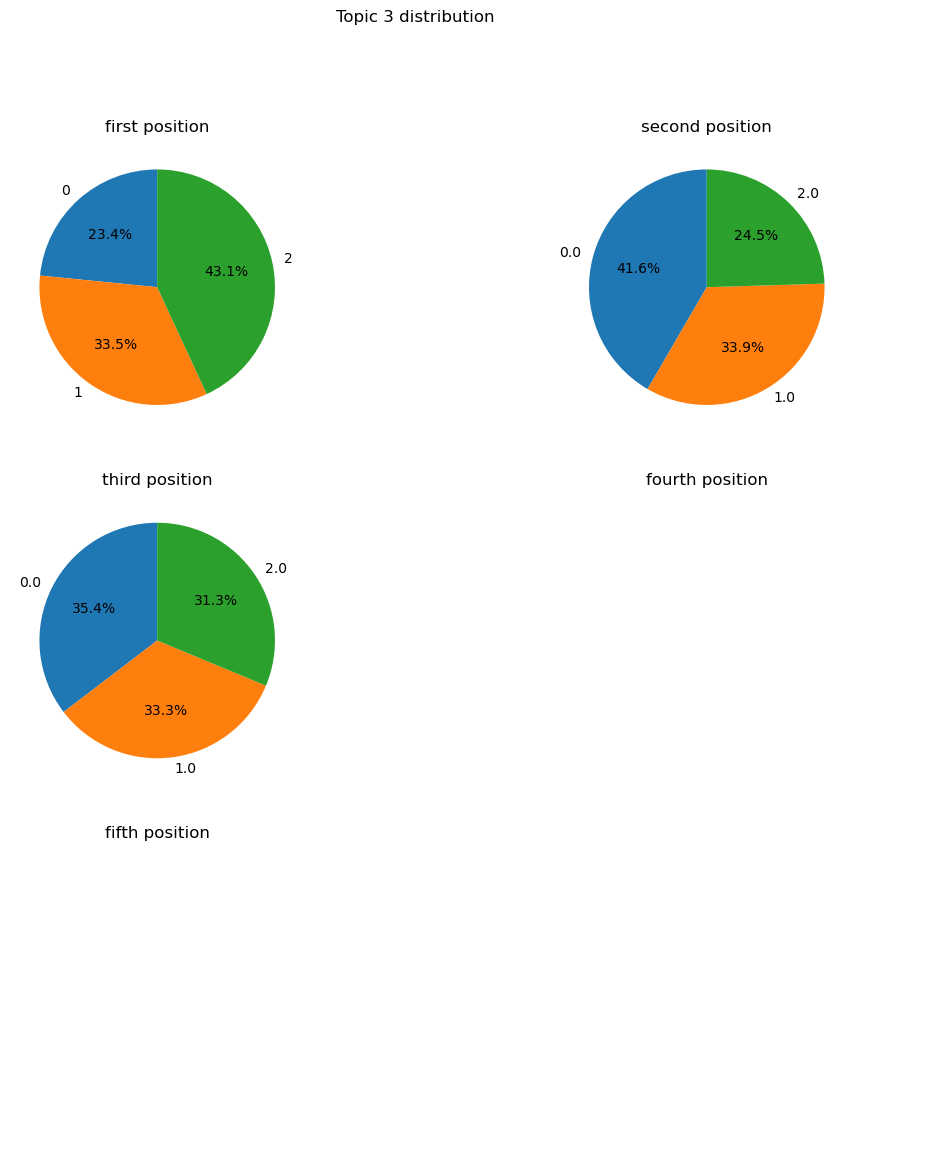

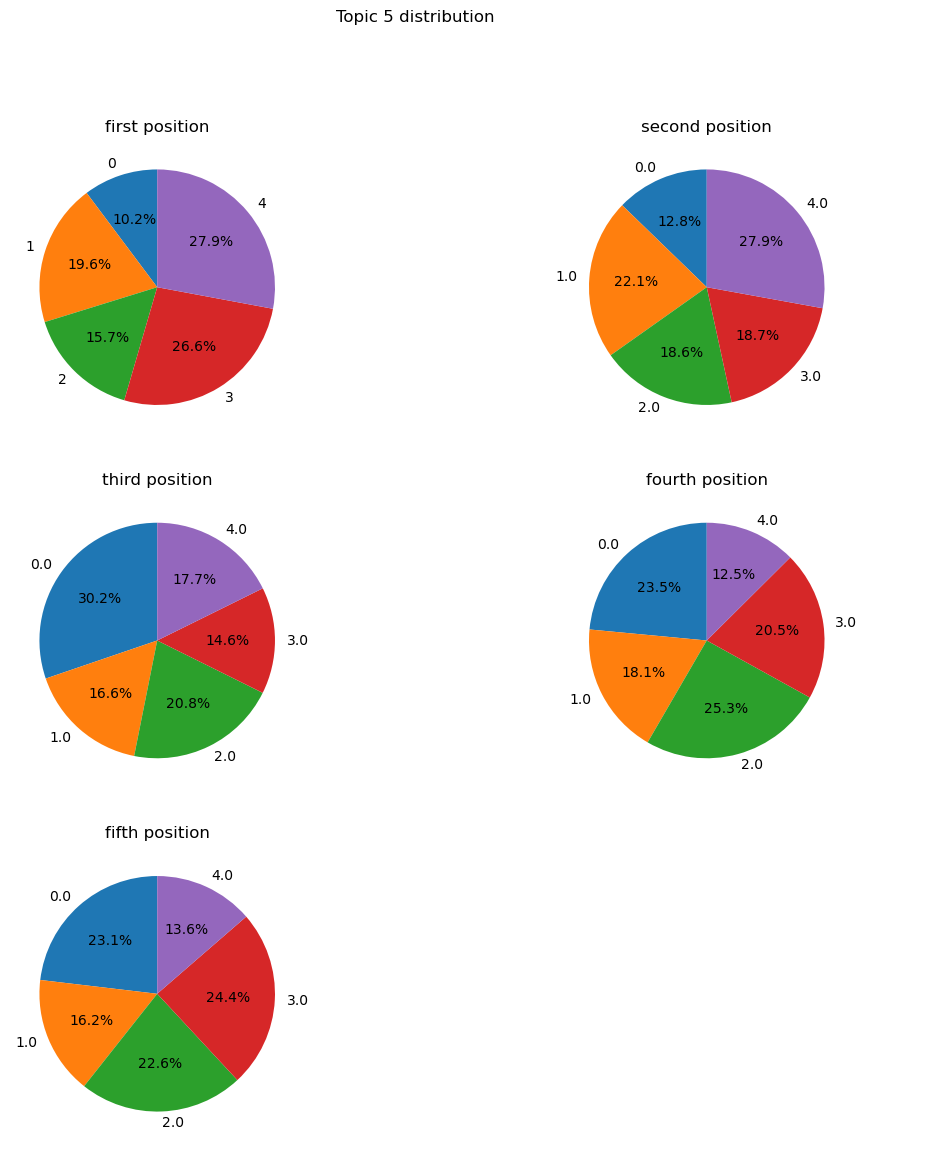

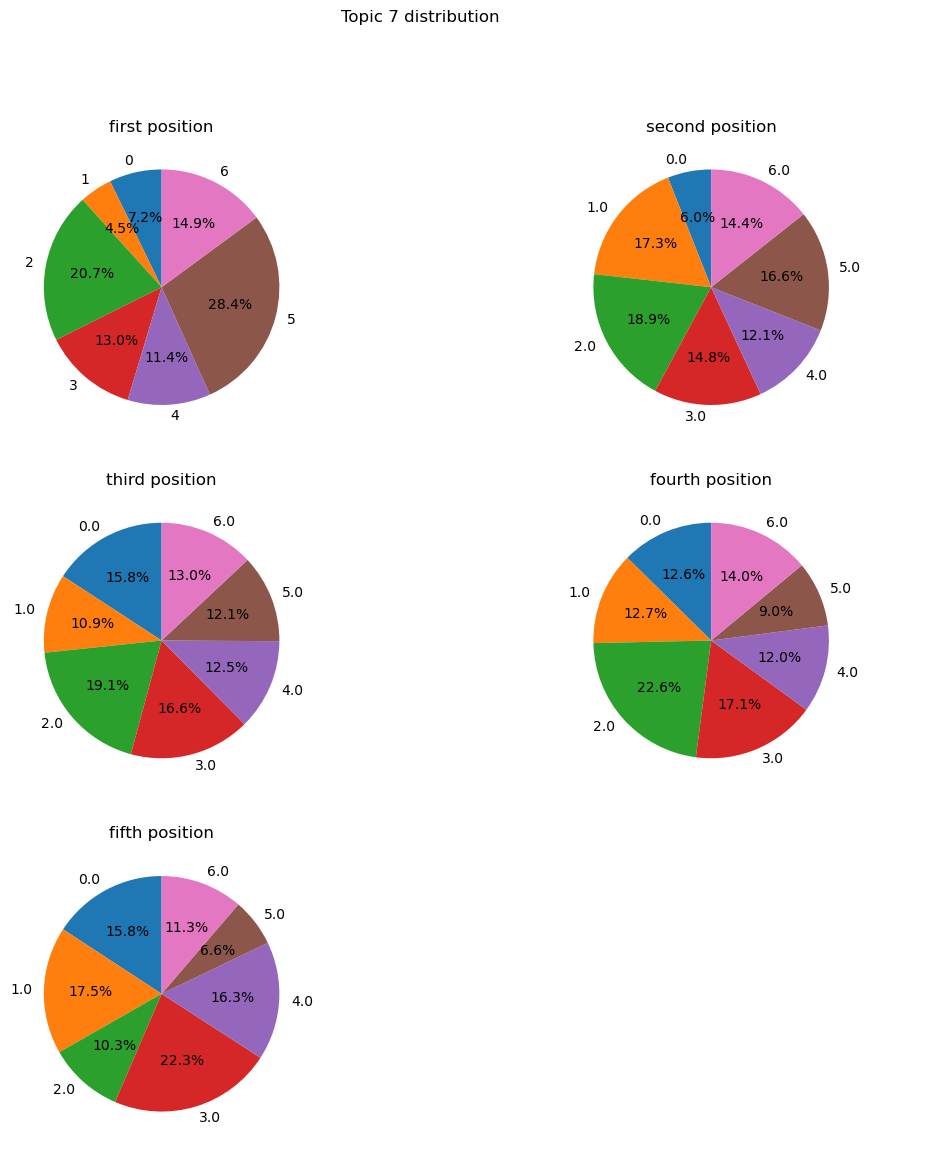

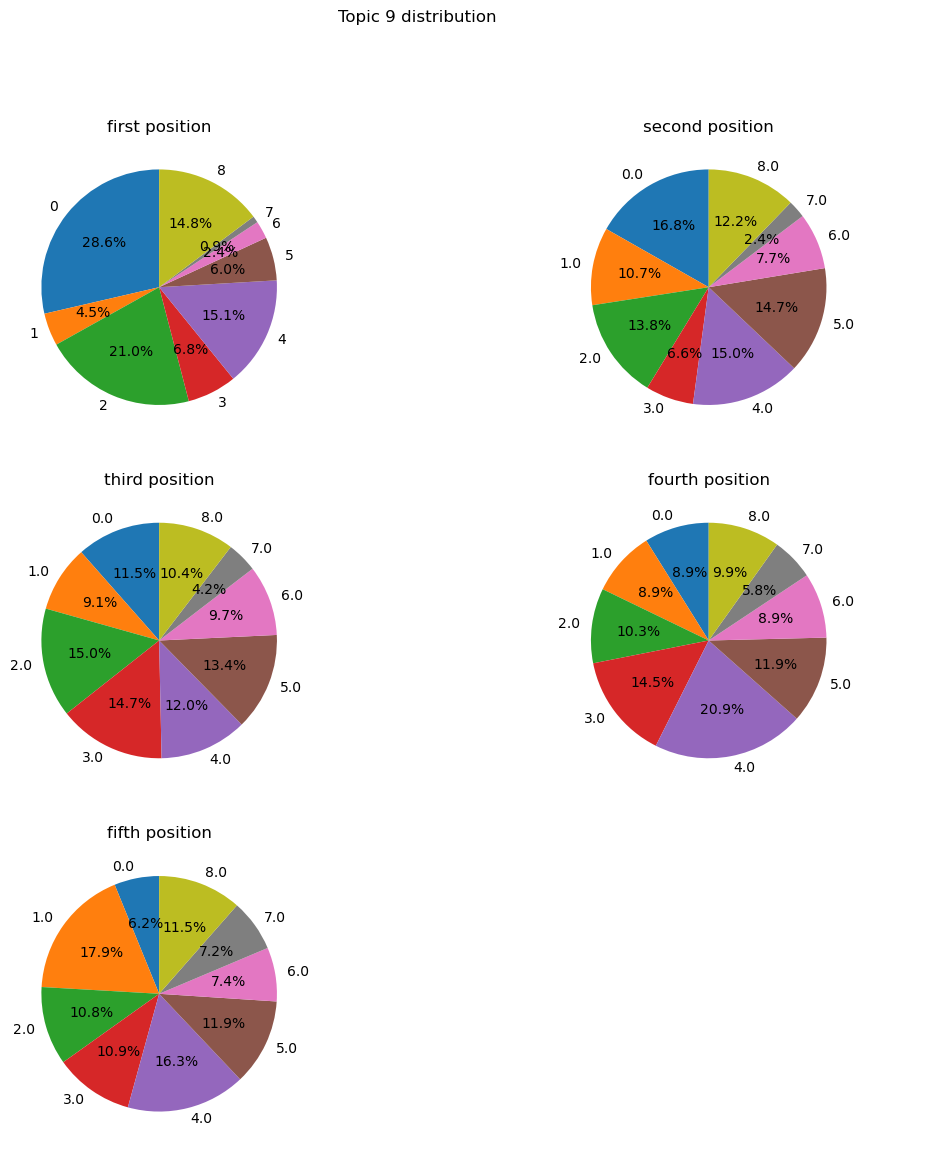

In [11]:
def posIdx_to_axs_idx(i):
    return i//2, i%2

for nb_topic in nb_topics:
    fig, axs = plt.subplots(3, len(topic_positions)//2, figsize=(13, 13))
    fig.suptitle(f"Topic {nb_topic} distribution")
    for i, pos in enumerate(topic_positions):
        ax = axs[posIdx_to_axs_idx(i)]
        df = stats_dict[(nb_topic, pos)]
        ax.pie(df[f"prob_of_topic_to_be_{pos}"], labels=df['Topic'], autopct='%1.1f%%', shadow=False, startangle=90)
        ax.set_title(f"{pos} position")
    ax = axs[posIdx_to_axs_idx(i+1)]
    ax.axis('off')
    plt.show()

---
## Draft 3

In [ ]:
df.Topics_from_3 = df.Topics_from_3.apply(lambda themes_list: [(models[0].show_topic(item[0],topn=15), item[1]) for item in themes_list])

In [ ]:
df.Topics_from_5 = df.Topics_from_5.apply(lambda themes_list: [(models[1].show_topic(item[0],topn=15), item[1]) for item in themes_list])

In [ ]:
df.Topics_from_7 = df.Topics_from_7.apply(lambda themes_list: [(models[2].show_topic(item[0],topn=15), item[1]) for item in themes_list])

In [ ]:
df.Topics_from_9 = df.Topics_from_9.apply(lambda themes_list: [(models[3].show_topic(item[0],topn=15), item[1]) for item in themes_list])

In [ ]:
df.to_csv('df_with_topics_v2.csv', index=False)

## Draft 2

In [ ]:
topic_range = range(3, 10, 2)
nb_words = 15

for nb_topics in topic_range:
    print(f"nb_topics: {nb_topics}, nb_words: {nb_words}")
    current_topics = get_LDA_topics_pipeline(comments_series, num_topics=nb_topics)
    with open(f"nbTopics_{nb_topics}_nbWords_{nb_words}.json", "w") as f:
        json.dump(current_topics, f)

In [ ]:
with open("./topic_raw_resuls/nbTopics_2_nbWords_10.json", "r") as file:
    topics = json.load(file)
topics

## Draft 1


In [ ]:
tokenize_comments = hlp.tokenize_comments(comments_series)
tokenize_comments[:2]

In [ ]:
from gensim.parsing.preprocessing import STOPWORDS

In [ ]:
STOPWORDS = list(STOPWORDS)
tokenize_comments = [[word for word in comment if word not in STOPWORDS] for comment in tokenize_comments]

In [ ]:
import string
PONCTUATION = string.punctuation
tokenize_comments = [[word for word in comment if word not in PONCTUATION] for comment in tokenize_comments]

In [ ]:
tokenize_comments[:2]

In [ ]:
d_r = hlp.get_dict_representation(tokenize_comments)

In [ ]:
bow = hlp.get_bow_representation(tokenize_comments,d_r)

In [ ]:
model = hlp.init_LDA_model(bow, d_r)
topics = hlp.get_LDA_topics(model)

In [ ]:
topics_3t = topics
topics_3t[0]

In [ ]:
model = hlp.init_LDA_model(bow, d_r, num_topics=6)
topics_6t = hlp.get_LDA_topics(model)

In [ ]:
for topic in topics_6t:
    print(topic)

In [ ]:
model = hlp.init_LDA_model(bow, d_r, num_topics=9)
topics_9t = hlp.get_LDA_topics(model)

In [ ]:
for topic in topics_9t:
    print(topic)

In [ ]:
model = hlp.init_LDA_model(bow, d_r, num_topics=15)
topics_9t = hlp.get_LDA_topics(model)

In [ ]:
for topic in topics_9t:
    print(topic)

#### Pipeline Test

In [ ]:
topcis_3t_pipeline = get_LDA_topics_pipeline(comments_series, num_topics=3, ponctuation=True, stopwords=True)

In [ ]:
for topic in topcis_3t_pipeline:
    print(topic)

In [ ]:
topcis_3t_pipeline = get_LDA_topics_pipeline(comments_series, num_topics=3, ponctuation=True, stopwords=True, fine_tune_stopwords=True)

In [ ]:
for topic in topcis_3t_pipeline:
    print(topic)

In [ ]:
topcis_3t_pipeline = get_LDA_topics_pipeline(comments_series, num_topics=3, ponctuation=True, stopwords=True, fine_tune_stopwords=True)

In [ ]:
for topic in topcis_3t_pipeline:
    print(topic)

In [ ]:
topics_6t_pipeline = get_LDA_topics_pipeline(comments_series, num_topics=6, ponctuation=True, stopwords=True, fine_tune_stopwords=True)

In [ ]:
for topic in topics_6t_pipeline:
    print(topic)

In [ ]:
print(type(topics_6t_pipeline))
print(type(topics_6t_pipeline[0]))

In [ ]:
import json

In [ ]:
with open("test.json", "w") as file:
    json.dump(topics_6t_pipeline, file)

In [ ]:
with open("test.json", "r") as file:
    topics_6t_read = json.load(file)

In [ ]:
topics_6t_read

#### Done with old version

In [ ]:
topics_3t = topics
topics_3t[0]

#### Done with old version

In [ ]:
topics_pipeline_6t = get_LDA_topics_pipeline(comments_series, num_topics=6)

In [ ]:
topics_pipeline_6t[0]

#### Done with old version

In [ ]:
topics_pipeline_9t = get_LDA_topics_pipeline(comments_series, num_topics=10)

In [ ]:
topics_pipeline_9t[0]

In [ ]:
topics_pipeline_3t_ws = get_LDA_topics_pipeline(comments_series, num_topics=3)

In [ ]:
topics_pipeline_3t_ws[0]